In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Load Environment variables

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import os

import json
import logging
import sys

import ipytest

ipytest.autoconfig(raise_on_error=True)

In [3]:
import os

KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME")
KAGGLE_KEY = os.environ.get("KAGGLE_KEY")

# Get the data

## Download data from kaggle

https://www.kaggle.com/code/gopal03/gbc-prediction-with-98-accuracy

In [5]:
!kaggle datasets download -d prishasawhney/mushroom-dataset

Dataset URL: https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset
License(s): other




  0%|          | 0.00/602k [00:00<?, ?B/s]
100%|██████████| 602k/602k [00:01<00:00, 552kB/s]
100%|██████████| 602k/602k [00:01<00:00, 551kB/s]


## Unzip 

In [6]:
import zipfile
with zipfile.ZipFile('mushroom-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('mushroom-dataset')

# Data Preprocessing

In [3]:
full_dataset = pd.read_csv('mushroom-dataset/mushroom_cleaned.csv')
full_dataset.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [5]:
full_dataset['class'].value_counts()

class
1    29675
0    24360
Name: count, dtype: int64

In [6]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


In [7]:
full_dataset.isna().sum() [ full_dataset.isna().sum() > 0] # Nan values

Series([], dtype: int64)

In [12]:
full_dataset.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


In [13]:
full_dataset.shape

(54035, 9)

<Axes: >

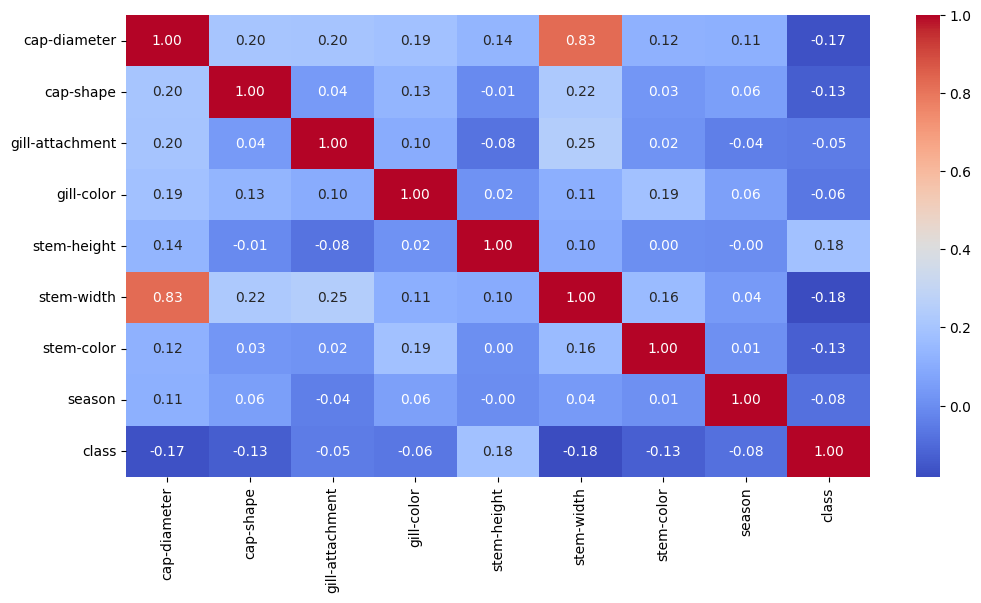

In [17]:
# correlation map

plt.figure(figsize=(12,6))
sns.heatmap(full_dataset.corr(), cmap='coolwarm', fmt='.2f', annot=True)

## Train test split

In [4]:
X = full_dataset.drop('class', axis=1)
y = full_dataset['class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [21]:
X_train.shape, X_test.shape

((43228, 8), (10807, 8))

# Build Light GBM Model

In [6]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data = lgb.Dataset(X_train, label=y_train)

num_round = 100
model = lgb.train(params, train_data, num_round)

# Evaluate Model

In [8]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred

array([0.18342239, 0.2172313 , 0.73170455, ..., 0.88371793, 0.08322016,
       0.06683185])

In [10]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
y_pred_binary

array([0, 0, 1, ..., 1, 0, 0])

In [11]:
from sklearn.metrics import classification_report

lr_report = classification_report(y_pred = y_pred_binary, y_true=y_test)
print(lr_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4912
           1       0.97      0.96      0.97      5895

    accuracy                           0.96     10807
   macro avg       0.96      0.96      0.96     10807
weighted avg       0.96      0.96      0.96     10807



# Plots

## ROC AUC

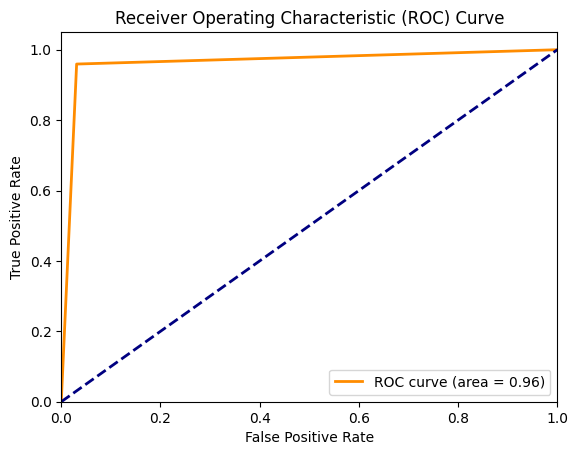

In [12]:
import sys

sys.path.append('../../../util')
from common_functions import plot_auc_roc

plot_auc_roc(y_test, y_pred_binary)

## AUPR

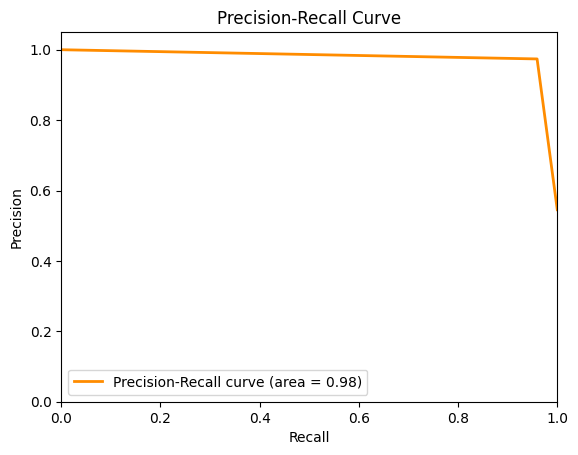

In [13]:
from common_functions import plot_aupr

plot_aupr(y_test, y_pred_binary)